In [1]:
import glob
import pandas as pd
from lfp_extracters import *
from sklearn.cross_validation import ShuffleSplit

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, LSTM, Dropout

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Split and Load Data
#### 80% train data, of which 20% is withheld for validation
#### 20% test data

In [2]:
def get_inds(): 
    
    numIter = 5
    rs = ShuffleSplit(1200, n_iter=numIter, test_size=.2, random_state=0)
    
    A_files = glob.glob('data/data/Stimulus_A/LFP_15_300/*.csv')
    B_files = glob.glob('data/data/Stimulus_B/LFP_15_300/*.csv')
    files = np.array(A_files + B_files)
    
    train_inds = []
    test_inds = []
    for train, test in rs: 
        train_inds.append(train)
        test_inds.append(test)
        
    train2 = []
    val_inds = []
    for t in train_inds: 
        s = ShuffleSplit(len(t), n_iter = 1, test_size = .2, random_state = 0)
        for train, val in s: 
            train2.append(train)
            val_inds.append(val)
        
    train_inds = train2
        
    return numIter, train_inds, val_inds, test_inds, files

In [3]:
def get_train_test_val(trial_num, train_inds, test_inds, val_inds, files):
    train_files = files[train_inds[trial_num]]
    test_files = files[test_inds[trial_num]]
    val_files = files[val_inds[trial_num]]
    return train_files, test_files, val_files

In [4]:
def make_test_df(test_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    l = []
    y_test = []
    bin_width = int(bin_width)
    
    for i in range(len(test_files)):
        n1 = np.genfromtxt(test_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        l.append(n_new) 
        if 'A' in test_files[i]: 
            y_test.append([0,1])
        else: 
            y_test.append([1,0])

    return np.array(l), y_test

In [5]:
def make_train_df(train_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_train = []
    bin_width = int(bin_width)
    
    for i in range(len(train_files)):
        n1 = np.genfromtxt(train_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new)
        if 'A' in train_files[i]: 
            y_train.append([0,1])
        else: 
            y_train.append([1,0])

    return np.array(list_), y_train

In [1]:
def make_val_df(val_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_val = []
    bin_width = int(bin_width)
    
    for i in range(len(val_files)):
        n1 = np.genfromtxt(val_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new)
        if 'A' in val_files[i]: 
            y_val.append([0,1])
        else: 
            y_val.append([1,0])

    return np.array(list_), y_val

## Threshold Crossing Rate

In [7]:
def threshold_crossing_rate(x, threshold, bin_width): 
    inds = range(0, 6001, int(bin_width))
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        count_above = np.sum(abs(np.diff(sub > threshold)), axis = 1)/float(bin_width)
        if hastime:
            t_seg = np.reshape(t[inds[i]], (1,)) #uses time stamp at beginning of each bin
            count_above = np.concatenate((count_above, t_seg))
        newx.append(count_above)
    return np.array(newx)

## Root Mean Square

In [8]:
def root_mean_square(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        rms = np.sqrt(np.mean(sub**2, axis = 1)) # , np.reshape((16,))
        
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

## Gamma Band Power

In [9]:
def power_gamma_band(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = [] 
    #make bandpass filter for 30-100Hz 
    fs = 6000
    nyq = 0.5 * fs
    cutOff_L = 30
    cutOff_H = 100
    low = cutOff_L / nyq
    high = cutOff_H / nyq
    order = 2
    b, a = signal.butter(order, [low, high], btype='band')
    
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        sub_f = signal.lfilter(b, a, sub)
        rms = np.sqrt(np.mean(sub**2, axis = 1))
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

## No Change 
#### Placeholder binning metric function. 

In [10]:
def no_change(x, threshold, bin_width): 
    return x

### CNN Model

In [11]:
def make_cnn(with_time, bin_width):
    # a linear stack of layers
    model_cnn = Sequential()
    
    if with_time: 
        x = 17
    else: 
        x = 16
    
#     model_cnn.add(Dropout(0.3, input_shape = (6000//bin_width, x)))
    model_cnn.add(Conv1D(2, kernel_size = (10), input_shape = (6000//bin_width, x), activation = 'relu', kernel_initializer='he_normal'))
#     model_cnn.add(Conv1D(2, kernel_size = (10), activation = 'relu', kernel_initializer='he_normal'))
    model_cnn.add(Flatten())
#     model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(32, activation = 'relu'))
#     model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(2, activation = 'softmax'))
    
    return model_cnn

### Fit, Predict

In [12]:
def makePredictions(model, train_df, train_l, test_df, test_l, val_df, val_l, with_time):
    a = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=a,
                  metrics=['accuracy'])
    print('Fitting...')
    History = model.fit(train_df, train_l, epochs = 200, validation_data = (val_df, val_l)) #batch_size = 1200*.8*.8
    print('Predicting...')
    pred = model.predict(test_df)
    return pred, History

## Main

In [13]:
def main(): 
    
    numIter, train_inds, val_inds, test_inds, files = get_inds()
    
    threshold = 0.010 
    bin_width = 265 
    bin_function = power_gamma_band
    with_time = False

    
    actual = []
    preds = []
    
    for i in range(0, numIter): 
        print('Cross val iteration ' + str(i+1) +  ' of ' + str(numIter))
        
        model_cnn = make_cnn(with_time, bin_width)
        model = model_cnn
    
        train_files, test_files, val_files = get_train_test_val(i, train_inds, test_inds, val_inds, files)
        
        test_df, y_test = make_test_df(test_files, with_time, bin_function, threshold, bin_width)
        train_df, y_train = make_train_df(train_files, with_time, bin_function, threshold, bin_width)
        val_df, y_val = make_val_df(val_files, with_time, bin_function, threshold, bin_width)
        
        if with_time: 
            all_times = np.concatenate((train_df[:,:,-1], test_df[:,:,-1], val_df[:,:,-1]))
            overall_time_mean = all_times.mean()
            overall_time_std = all_times.std() * 100

            new_times_train = (train_df[:,:, -1]-overall_time_mean)/overall_time_std
            new_times_test = (test_df[:,:,-1]-overall_time_mean)/overall_time_std
            new_times_val = (val_df[:,:, -1]-overall_time_mean)/overall_time_std
            train_df[:,:,-1] = new_times_train
            test_df[:,:,-1] = new_times_test
            val_df[:,:,-1] = new_times_val

        actual.append(y_test)
        
        pred, History = makePredictions(model, train_df, np.array(y_train), test_df, \
                                        np.array(y_test), val_df, np.array(y_val), with_time)

        preds.append(pred)
        
    return preds, actual, History

In [14]:
if __name__ == '__main__':
    preds, actual, History = main()

Cross val iteration 1 of 5
Fitting...
Train on 768 samples, validate on 192 samples
Epoch 1/200
768/768 [==============================] - 0s 451us/step - loss: 0.6858 - acc: 0.6237 - val_loss: 0.6843 - val_acc: 0.5833
Epoch 2/200
768/768 [==============================] - 0s 66us/step - loss: 0.6708 - acc: 0.6354 - val_loss: 0.6785 - val_acc: 0.5833
Epoch 3/200
768/768 [==============================] - 0s 84us/step - loss: 0.6604 - acc: 0.6354 - val_loss: 0.6810 - val_acc: 0.5833
Epoch 4/200
768/768 [==============================] - 0s 85us/step - loss: 0.6559 - acc: 0.6354 - val_loss: 0.6828 - val_acc: 0.5833
Epoch 5/200
768/768 [==============================] - 0s 83us/step - loss: 0.6594 - acc: 0.6354 - val_loss: 0.6816 - val_acc: 0.5833
Epoch 6/200
768/768 [==============================] - 0s 77us/step - loss: 0.6559 - acc: 0.6354 - val_loss: 0.6823 - val_acc: 0.5833
Epoch 7/200
768/768 [==============================] - 0s 80us/step - loss: 0.6592 - acc: 0.6354 - val_loss: 0.

768/768 [==============================] - 0s 88us/step - loss: 0.5106 - acc: 0.7630 - val_loss: 0.5166 - val_acc: 0.7396
Epoch 121/200
768/768 [==============================] - 0s 90us/step - loss: 0.5045 - acc: 0.7643 - val_loss: 0.5192 - val_acc: 0.6979
Epoch 122/200
768/768 [==============================] - 0s 72us/step - loss: 0.5048 - acc: 0.7604 - val_loss: 0.5159 - val_acc: 0.7448
Epoch 123/200
768/768 [==============================] - 0s 83us/step - loss: 0.5055 - acc: 0.7565 - val_loss: 0.5170 - val_acc: 0.7552
Epoch 124/200
768/768 [==============================] - 0s 89us/step - loss: 0.5086 - acc: 0.7513 - val_loss: 0.5169 - val_acc: 0.7552
Epoch 125/200
768/768 [==============================] - 0s 76us/step - loss: 0.5050 - acc: 0.7500 - val_loss: 0.5151 - val_acc: 0.7344
Epoch 126/200
768/768 [==============================] - 0s 76us/step - loss: 0.5087 - acc: 0.7370 - val_loss: 0.5150 - val_acc: 0.7292
Epoch 127/200
768/768 [==============================] - 0s 85

768/768 [==============================] - 0s 87us/step - loss: 0.4754 - acc: 0.7734 - val_loss: 0.5021 - val_acc: 0.7500
Epoch 181/200
768/768 [==============================] - 0s 82us/step - loss: 0.4783 - acc: 0.7656 - val_loss: 0.5158 - val_acc: 0.7396
Epoch 182/200
768/768 [==============================] - 0s 81us/step - loss: 0.4824 - acc: 0.7604 - val_loss: 0.5072 - val_acc: 0.7552
Epoch 183/200
768/768 [==============================] - 0s 81us/step - loss: 0.4993 - acc: 0.7474 - val_loss: 0.5037 - val_acc: 0.7500
Epoch 184/200
768/768 [==============================] - 0s 85us/step - loss: 0.4763 - acc: 0.7852 - val_loss: 0.5036 - val_acc: 0.7240
Epoch 185/200
768/768 [==============================] - 0s 84us/step - loss: 0.4754 - acc: 0.7682 - val_loss: 0.5004 - val_acc: 0.7604
Epoch 186/200
768/768 [==============================] - 0s 77us/step - loss: 0.4741 - acc: 0.7747 - val_loss: 0.4997 - val_acc: 0.7656
Epoch 187/200
768/768 [==============================] - 0s 84

Epoch 40/200
768/768 [==============================] - 0s 86us/step - loss: 0.6559 - acc: 0.6354 - val_loss: 0.6843 - val_acc: 0.5833
Epoch 41/200
768/768 [==============================] - 0s 86us/step - loss: 0.6554 - acc: 0.6354 - val_loss: 0.6847 - val_acc: 0.5833
Epoch 42/200
768/768 [==============================] - 0s 87us/step - loss: 0.6568 - acc: 0.6354 - val_loss: 0.6854 - val_acc: 0.5833
Epoch 43/200
768/768 [==============================] - 0s 84us/step - loss: 0.6567 - acc: 0.6354 - val_loss: 0.6849 - val_acc: 0.5833
Epoch 44/200
768/768 [==============================] - 0s 76us/step - loss: 0.6571 - acc: 0.6354 - val_loss: 0.6842 - val_acc: 0.5833
Epoch 45/200
768/768 [==============================] - 0s 83us/step - loss: 0.6563 - acc: 0.6354 - val_loss: 0.6851 - val_acc: 0.5833
Epoch 46/200
768/768 [==============================] - 0s 84us/step - loss: 0.6568 - acc: 0.6354 - val_loss: 0.6845 - val_acc: 0.5833
Epoch 47/200
768/768 [==============================] -

Epoch 160/200
768/768 [==============================] - 0s 86us/step - loss: 0.6564 - acc: 0.6354 - val_loss: 0.6848 - val_acc: 0.5833
Epoch 161/200
768/768 [==============================] - 0s 89us/step - loss: 0.6561 - acc: 0.6354 - val_loss: 0.6854 - val_acc: 0.5833
Epoch 162/200
768/768 [==============================] - 0s 87us/step - loss: 0.6569 - acc: 0.6354 - val_loss: 0.6849 - val_acc: 0.5833
Epoch 163/200
768/768 [==============================] - 0s 85us/step - loss: 0.6561 - acc: 0.6354 - val_loss: 0.6850 - val_acc: 0.5833
Epoch 164/200
768/768 [==============================] - 0s 81us/step - loss: 0.6561 - acc: 0.6354 - val_loss: 0.6844 - val_acc: 0.5833
Epoch 165/200
768/768 [==============================] - 0s 83us/step - loss: 0.6576 - acc: 0.6354 - val_loss: 0.6844 - val_acc: 0.5833
Epoch 166/200
768/768 [==============================] - 0s 78us/step - loss: 0.6557 - acc: 0.6354 - val_loss: 0.6851 - val_acc: 0.5833
Epoch 167/200
768/768 [=========================

Epoch 20/200
768/768 [==============================] - 0s 66us/step - loss: 0.6496 - acc: 0.6354 - val_loss: 0.6736 - val_acc: 0.5833
Epoch 21/200
768/768 [==============================] - 0s 74us/step - loss: 0.6481 - acc: 0.6354 - val_loss: 0.6722 - val_acc: 0.5833
Epoch 22/200
768/768 [==============================] - 0s 86us/step - loss: 0.6453 - acc: 0.6354 - val_loss: 0.6736 - val_acc: 0.5833
Epoch 23/200
768/768 [==============================] - 0s 85us/step - loss: 0.6473 - acc: 0.6354 - val_loss: 0.6687 - val_acc: 0.5833
Epoch 24/200
768/768 [==============================] - 0s 92us/step - loss: 0.6441 - acc: 0.6354 - val_loss: 0.6709 - val_acc: 0.5833
Epoch 25/200
768/768 [==============================] - 0s 85us/step - loss: 0.6422 - acc: 0.6354 - val_loss: 0.6655 - val_acc: 0.5833
Epoch 26/200
768/768 [==============================] - 0s 82us/step - loss: 0.6386 - acc: 0.6354 - val_loss: 0.6665 - val_acc: 0.5833
Epoch 27/200
768/768 [==============================] -

Epoch 140/200
768/768 [==============================] - 0s 82us/step - loss: 0.4950 - acc: 0.7552 - val_loss: 0.5083 - val_acc: 0.7031
Epoch 141/200
768/768 [==============================] - 0s 84us/step - loss: 0.4906 - acc: 0.7617 - val_loss: 0.5249 - val_acc: 0.6875
Epoch 142/200
768/768 [==============================] - ETA: 0s - loss: 0.4917 - acc: 0.774 - 0s 86us/step - loss: 0.4903 - acc: 0.7734 - val_loss: 0.5068 - val_acc: 0.7135
Epoch 143/200
768/768 [==============================] - 0s 82us/step - loss: 0.4916 - acc: 0.7578 - val_loss: 0.5076 - val_acc: 0.7031
Epoch 144/200
768/768 [==============================] - 0s 88us/step - loss: 0.4845 - acc: 0.7695 - val_loss: 0.5052 - val_acc: 0.7240
Epoch 145/200
768/768 [==============================] - 0s 86us/step - loss: 0.4880 - acc: 0.7682 - val_loss: 0.5048 - val_acc: 0.7292
Epoch 146/200
768/768 [==============================] - 0s 90us/step - loss: 0.4877 - acc: 0.7786 - val_loss: 0.5067 - val_acc: 0.7031
Epoch 147/

Epoch 59/200
768/768 [==============================] - 0s 87us/step - loss: 0.5386 - acc: 0.7070 - val_loss: 0.5670 - val_acc: 0.6354
Epoch 60/200
768/768 [==============================] - 0s 90us/step - loss: 0.5506 - acc: 0.7057 - val_loss: 0.5517 - val_acc: 0.6979
Epoch 61/200
768/768 [==============================] - 0s 87us/step - loss: 0.5306 - acc: 0.7161 - val_loss: 0.5347 - val_acc: 0.7500
Epoch 62/200
768/768 [==============================] - 0s 87us/step - loss: 0.5310 - acc: 0.7396 - val_loss: 0.5310 - val_acc: 0.7031
Epoch 63/200
768/768 [==============================] - 0s 83us/step - loss: 0.5361 - acc: 0.7227 - val_loss: 0.5494 - val_acc: 0.6875
Epoch 64/200
768/768 [==============================] - 0s 82us/step - loss: 0.5422 - acc: 0.6992 - val_loss: 0.5407 - val_acc: 0.6875
Epoch 65/200
768/768 [==============================] - 0s 88us/step - loss: 0.5368 - acc: 0.7109 - val_loss: 0.5327 - val_acc: 0.7500
Epoch 66/200
768/768 [==============================] -

768/768 [==============================] - 0s 88us/step - loss: 0.4536 - acc: 0.7839 - val_loss: 0.4944 - val_acc: 0.7604
Epoch 180/200
768/768 [==============================] - 0s 88us/step - loss: 0.4529 - acc: 0.7865 - val_loss: 0.5107 - val_acc: 0.7604
Epoch 181/200
768/768 [==============================] - 0s 84us/step - loss: 0.4562 - acc: 0.7773 - val_loss: 0.5081 - val_acc: 0.7083
Epoch 182/200
768/768 [==============================] - 0s 91us/step - loss: 0.4691 - acc: 0.7773 - val_loss: 0.5682 - val_acc: 0.6927
Epoch 183/200
768/768 [==============================] - 0s 80us/step - loss: 0.4866 - acc: 0.7409 - val_loss: 0.4941 - val_acc: 0.7708
Epoch 184/200
768/768 [==============================] - 0s 87us/step - loss: 0.4632 - acc: 0.7852 - val_loss: 0.4986 - val_acc: 0.7760
Epoch 185/200
768/768 [==============================] - 0s 86us/step - loss: 0.4524 - acc: 0.7891 - val_loss: 0.4965 - val_acc: 0.7500
Epoch 186/200
768/768 [==============================] - 0s 86

Epoch 39/200
768/768 [==============================] - 0s 85us/step - loss: 0.5729 - acc: 0.6523 - val_loss: 0.5805 - val_acc: 0.7083
Epoch 40/200
768/768 [==============================] - 0s 89us/step - loss: 0.5642 - acc: 0.6875 - val_loss: 0.5751 - val_acc: 0.7188
Epoch 41/200
768/768 [==============================] - 0s 94us/step - loss: 0.5581 - acc: 0.6979 - val_loss: 0.5743 - val_acc: 0.5990
Epoch 42/200
768/768 [==============================] - 0s 91us/step - loss: 0.5509 - acc: 0.6810 - val_loss: 0.5639 - val_acc: 0.7135
Epoch 43/200
768/768 [==============================] - 0s 81us/step - loss: 0.5520 - acc: 0.7083 - val_loss: 0.5605 - val_acc: 0.7083
Epoch 44/200
768/768 [==============================] - 0s 76us/step - loss: 0.5490 - acc: 0.7070 - val_loss: 0.5702 - val_acc: 0.6042
Epoch 45/200
768/768 [==============================] - 0s 88us/step - loss: 0.5452 - acc: 0.6966 - val_loss: 0.5598 - val_acc: 0.6562
Epoch 46/200
768/768 [==============================] -

768/768 [==============================] - 0s 88us/step - loss: 0.4706 - acc: 0.7826 - val_loss: 0.4996 - val_acc: 0.7552
Epoch 160/200
768/768 [==============================] - 0s 87us/step - loss: 0.4849 - acc: 0.7695 - val_loss: 0.5099 - val_acc: 0.7760
Epoch 161/200
768/768 [==============================] - 0s 83us/step - loss: 0.4758 - acc: 0.7734 - val_loss: 0.5018 - val_acc: 0.7188
Epoch 162/200
768/768 [==============================] - 0s 83us/step - loss: 0.4753 - acc: 0.7773 - val_loss: 0.5058 - val_acc: 0.7552
Epoch 163/200
768/768 [==============================] - 0s 87us/step - loss: 0.4687 - acc: 0.7721 - val_loss: 0.5047 - val_acc: 0.7500
Epoch 164/200
768/768 [==============================] - 0s 86us/step - loss: 0.4788 - acc: 0.7708 - val_loss: 0.5000 - val_acc: 0.7552
Epoch 165/200
768/768 [==============================] - 0s 84us/step - loss: 0.4711 - acc: 0.7604 - val_loss: 0.5044 - val_acc: 0.7500
Epoch 166/200
768/768 [==============================] - 0s 91

## Plot Learning Curves

In [2]:
import matplotlib.pyplot as plt 

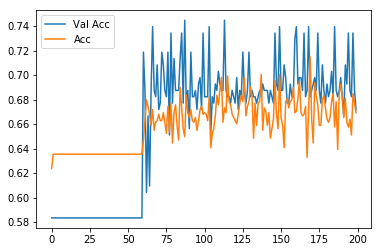

In [100]:
plt.plot(History.history['val_acc'])
plt.plot(History.history['acc'])
plt.legend(['Val Acc', 'Acc'])
plt.show()

## Compute Prediction Accuracy

In [16]:
preds = np.around(preds, decimals = 0)
preds

array([[[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        ..., 
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        ..., 
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        ..., 
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]], dtype=float32)

In [17]:
totals = []
for i in range(0, len(preds)): 
    current_pred = preds[i]
    current_real = actual[i]
    total = 0
    for j in range(0, len(preds[0])):
        if current_pred[j][0] == current_real[j][0]: 
            total += 1
    totals.append(total)
    
totals

[158, 122, 175, 180, 180]

In [18]:
i = 0
accs = []
for t in totals: 
    acc = t/len(preds[i])
    i+=1
    accs.append(acc)
accs

[0.6583333333333333, 0.5083333333333333, 0.7291666666666666, 0.75, 0.75]

In [19]:
np.std(accs)

0.091818056805595474

In [20]:
np.mean(accs)

0.67916666666666659